# Baseline Model

In [1]:
import pandas as pd
ks = pd.read_csv('D:/input/kickstarter-projects/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])
ks.head(6)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


In [2]:
print('Unique values in `state` column:', list(ks.state.unique()))

Unique values in `state` column: ['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']


Using the features the machine learning techniques will attempt to predict if the kick starters will succeed or not.

## Preparing the target column

First the state column will be considered the target for the model. The `live` projects will be dropped and "successful" projects will be counted as `outcome = 1` and every other state as `outcome = 0`. 

In [3]:
# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

## Converting timestamps

The `launched` feature will be converted into categorical features. Since the columns are timestamp data, the date and time values can be accessed through the `.dt` attribute timestamp column.

In [4]:
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

## Preparing categorical variables

The categorical variables `category`, `currency`, and `country` will be converted into integers for the model to use as data. Scikit-learn's `LabelEncoder` cab assign integer values to each categorical feature.

In [5]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()

# Apply the label encoder to each column
encoded = ks[cat_features].apply(encoder.fit_transform)

# Collect features into new DataFrame
# Since ks and encoded have the same index they can be easily joined
data = ks[['goal', 'hour', 'day', 'month', 'year', 'outcome']].join(encoded)
data.head()

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22
2,45000.0,0,12,1,2013,0,93,13,22
3,5000.0,3,17,3,2012,0,90,13,22
4,19500.0,8,4,7,2015,0,55,13,22


In [6]:
# Creating training data and validation data. 
# 10% data will be used for validation, 10% for testing, and 80% for training

valid_fraction = 0.1
valid_size = int(len(data)*valid_fraction)

train = data[:-2*valid_size]
valid = data[-2*valid_size:-valid_size]
test = data[-valid_size:]

## Train model

The model used will be the LightGBM model which is a tree-based model that can have better performance than XGBoost, and fast to train.

There will be no hyperparameter optimization as it is outwith the scope. The models will not have the best performance, but the performance will improve with feature engineering.

In [7]:
import lightgbm as lgb

feature_cols = train.columns.drop('outcome')

dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

param = {'num_leaves': 64, 'objective':'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

In [8]:
from sklearn import metrics
ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

print(f"Test AUC score: {score}")

Test AUC score: 0.747615303004287


# Base Line Exercise

In [9]:
click_data = pd.read_csv('D:/input/feature-engineering-data/train_sample.csv',
                         parse_dates=['click_time'])
click_data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [10]:
# Add new columns for timestamp features day, hour, minute, and second
clicks = click_data.copy()
clicks['day'] = clicks['click_time'].dt.day.astype('uint8')
# Fill in the rest
clicks['hour'] = clicks['click_time'].dt.hour.astype('uint8')
clicks['minute'] = clicks['click_time'].dt.minute.astype('uint8')
clicks['second'] = clicks['click_time'].dt.second.astype('uint8')

cat_features = ['ip', 'app', 'device', 'os', 'channel']
encoder = LabelEncoder()
# Create new columns in clicks using preprocessing.LabelEncoder()
for feature in cat_features:
    encoded = encoder.fit_transform(clicks[feature])
    clicks[feature+'_labels'] = encoded
    
clicks.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_labels,app_labels,device_labels,os_labels,channel_labels
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38,15220,11,1,13,159
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27,18448,24,1,17,67
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24,17663,11,1,19,52
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8,16496,12,1,13,146
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9,11852,11,1,1,45


In [11]:
# Predicting clicks, one has to be careful not to include future variables in
# the test time series. Otherwise future data leaking into the past will cause
# overestimation.

feature_cols = ['day', 'hour', 'minute', 'second', 
                'ip_labels', 'app_labels', 'device_labels',
                'os_labels', 'channel_labels']

valid_fraction = 0.1
clicks_srt = clicks.sort_values('click_time')
valid_rows = int(len(clicks_srt) * valid_fraction)
train = clicks_srt[:-valid_rows * 2]
# valid size == test size, last two sections of the data
valid = clicks_srt[-valid_rows * 2:-valid_rows]
test = clicks_srt[-valid_rows:]

dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])
dtest = lgb.Dataset(test[feature_cols], label=test['is_attributed'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10)

[1]	valid_0's auc: 0.932413
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.530091
[3]	valid_0's auc: 0.446663
[4]	valid_0's auc: 0.608956
[5]	valid_0's auc: 0.608624
[6]	valid_0's auc: 0.809223
[7]	valid_0's auc: 0.810089
[8]	valid_0's auc: 0.810314
[9]	valid_0's auc: 0.80959
[10]	valid_0's auc: 0.809999
[11]	valid_0's auc: 0.809321
Early stopping, best iteration is:
[1]	valid_0's auc: 0.932413


In [12]:
ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['is_attributed'], ypred)
print(f"Test score: {score}")

Test score: 0.7811898797595189


# Categorical Encodings

Two encoders have been covered covered so far: **One-Hot Encoder** and **Label Encoding**. The three next encoders covered will be **Count Encoding**, **Target Encoding**, and **CatBoost Encoding**.

In [13]:
 ks = pd.read_csv('D:/input/kickstarter-projects/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
data = ks[data_cols].join(encoded)

# Defining  functions that will help us test our encodings
import lightgbm as lgb
from sklearn import metrics

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    
# Train a model (on the baseline data)
train, valid, test = get_data_splits(data)
train_model(train, valid)

Validation AUC score: 0.7467


## Count Encoding

Count encoding replaces each categorical value with the number of times it appears in the dataset. If `GB` appears in the dataset 10 times then `GB` will be replaced with the number `10`.

The `categorical-encodings` package will be used with it's encoder as `CountEncoder`. These encoders will work similarly to sklearn transformers with `.fit` and `.transform` methods.

In [14]:
import category_encoders as ce

cat_features = ['category', 'currency', 'country']

# Create the encoder
count_enc = ce.CountEncoder()

# Transform the features, rename the columns with the _count suffix, and 
# join to dataframe
count_encoded = count_enc.fit_transform(ks[cat_features])
data = data.join(count_encoded.add_suffix("_count"))

# Train a model
train, valid, test = get_data_splits(data)
train_model(train, valid)

Validation AUC score: 0.7486


## Target Encoding

Target encoding replaces a categorical value with the average value of the target for that value of the feature. For example, given the country value "CA", the average outcome for all rows is calculated with `country == 'CA'`, around 0.28. This is usually blended with the target probability over the entire dataset to reduce the variance of values with few occurrences.

The targets are used to create the features using this technique. By the validation or test data with the target encodings a form of target leakage occurs. Instead, the target encodings should only be leared from the training dataset and applied to the other datasets.

The package `TargetEncoder` is included with `category_encoders` and is similarly implemented as `CountEncoder`.

In [15]:
# Create the encoder
target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename the columns with '_target' suffix, and join to 
# dataframe
train_TE = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid_TE = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

# Train a model
train_model(train_TE, valid_TE)

Validation AUC score: 0.7491


## CatBoost Encoding

The third encoder is CatBoost. CatBoost Encoding is based on target probability similar to target encoding. The CatBoost probability is calculated based on the preceeding rows before it. 

In [16]:
# Create the encoder
target_enc = ce.CatBoostEncoder(cols=cat_features)
target_enc.fit(train[cat_features], train['outcome'])

# Transform the features, rename columsn with '_cb' suffix, and join dataframe
train_CBE = train.join(target_enc.transform(train[cat_features]).add_suffix('_cb'))
valid_CBE = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_cb'))

# Train a model
train_model(train_CBE, valid_CBE)

Validation AUC score: 0.7492


# Categorical Encoding: Exercises

In [17]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics
import lightgbm as lgb

clicks = pd.read_parquet('D:/input/feature-engineering-data/baseline_data.pqt')

In [18]:
def get_data_splits(dataframe, valid_fraction=0.1):
    """Splits a dataframe into train, validation, and test sets.

    First, orders by the column 'click_time'. Set the size of the 
    validation and test sets with the valid_fraction keyword argument.
    """

    dataframe = dataframe.sort_values('click_time')
    valid_rows = int(len(dataframe) * valid_fraction)
    train = dataframe[:-valid_rows * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_rows * 2:-valid_rows]
    test = dataframe[-valid_rows:]
    
    return train, valid, test

def train_model(train, valid, test=None, feature_cols=None):
    if feature_cols is None:
        feature_cols = train.columns.drop(['click_time', 'attributed_time',
                                           'is_attributed'])
    dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])
    
    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    num_round = 1000
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], 
                    early_stopping_rounds=20, verbose_eval=False)
    
    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['is_attributed'], valid_pred)
    print(f"Validation AUC score: {valid_score}")
    
    if test is not None: 
        test_pred = bst.predict(test[feature_cols])
        test_score = metrics.roc_auc_score(test['is_attributed'], test_pred)
        return bst, valid_score, test_score
    else:
        return bst, valid_score

In [19]:
print("Baseline model")
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

Baseline model
Validation AUC score: 0.9622743228943659


In [20]:
cat_features = ['ip', 'app', 'device', 'os', 'channel']
train, valid, test = get_data_splits(clicks)

In [21]:
# Count Encoding

# Create the count encoder
count_enc = ce.CountEncoder(cols=cat_features)

# Learn encoding from the training set
count_enc.fit(train[cat_features])

# Apply encoding to the train and validation sets as new columns
# Make sure to add `_count` as a suffix to the new columns
train_encoded = train.join(count_enc.transform(train[cat_features]).add_suffix('_count'))
valid_encoded = valid.join(count_enc.transform(valid[cat_features]).add_suffix('_count'))

In [22]:
# Train the model on the encoded datasets
# This can take around 30 seconds to complete
_ = train_model(train_encoded, valid_encoded)

Validation AUC score: 0.9653051135205329


In [23]:
# Target Encoding

# Create the target encoder. You can find this easily by using tab completion.
# Start typing ce. the press Tab to bring up a list of classes and functions.
target_enc = ce.TargetEncoder(cols=cat_features)

# Learn encoding from the training set. Use the 'is_attributed' column as the target.
target_enc.fit(train[cat_features], train['is_attributed'])

# Apply encoding to the train and validation sets as new columns
# Make sure to add `_target` as a suffix to the new columns
train_encoded = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid_encoded = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

_ = train_model(train_encoded, valid_encoded)

Validation AUC score: 0.9540530347873288


In [24]:
# CatBoost Encoding

# Remove IP from the encoded features
cat_features = ['app', 'device', 'os', 'channel']

# Create the CatBoost encoder
cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)

# Learn encoding from the training set
cb_enc.fit(train[cat_features], train['is_attributed'])

# Apply encoding to the train and validation sets as new columns
# Make sure to add `_cb` as a suffix to the new columns
train_encoded = train.join(cb_enc.transform(train[cat_features]).add_suffix('_cb'))
valid_encoded = valid.join(cb_enc.transform(valid[cat_features]).add_suffix('_cb'))

_ = train_model(train_encoded, valid_encoded)

Validation AUC score: 0.962868024575231


# Feature Generation

Creating features from raw data is a way to potentially improve the model. In the kickstarter data, the number of total projects in the last week can be calculated and the duration of the fundraising period. The features created will be different for every dataset through creativity and experimentation. Working with only one table limits what can be done as new created features can be created based on mutliple tables with relevant data.

New features can still be made from categorical features and generated numerical features.

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import LabelEncoder

ks = pd.read_csv('D:/input/kickstarter-projects/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

## Interactions

One way of creating new features is to combine categorical variables. One record with the country `'CA'` and category of `'Music'`, a new value of `'CA_Music'` can be created. This new categorical feature can provide information about correlations between categorical variables. This is typically called an **interaction** feature.

Interaction features are build from categorical features. More that three strings can be used, but this leads to diminishing returns.

With Pandas, the string coloumns are added together like regular Python strings.

The new interaction feature can then be label encoded and added to the data.

In [26]:
interactions = ks['category'] + "_" + ks['country']
print(interactions.head(5))

0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
dtype: object


In [27]:
label_enc = LabelEncoder()
data_interaction = baseline_data.assign(category_country=label_enc.fit_transform(interactions))
data_interaction.head()

,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


## Number of projects in the last week

The number of projects lauched in the preceeding week for each record are counted. The `.rolling` method is used along with the `"launched"` columns as the index. The series is created using `ks.launched` as index and `ks.index` as the values, sorted by time. Using the time series as an index allows the rolling window size to be determined in terms of hours, days, weeks, and so on.

In [28]:
# First, create a Series with a timestamp index
launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
launched.head(20)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
2009-04-29 04:37:37     98954
2009-04-29 05:26:32    342226
2009-04-29 06:43:44    275091
2009-04-29 13:52:03    284115
2009-04-29 22:08:13     32898
Name: count_7_days, dtype: int64

There are some illogical dates which would have been dealth with in cleaning, but here they will be ignored.

With a timeseries index, the `.rolling` can be used to select time periods for the window. For example `launched.rolling('7d')` creates a window that contains the data in the previous 7 days. The window contains the current record, so if the count of all previous projects is wanted except the current one, then the one will need to be subtracted. The results are plotted to check if it's correct.

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64


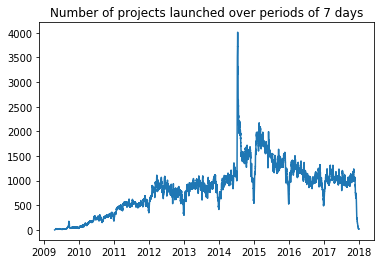

In [29]:
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

# Ignore records with broken launch dates
plt.plot(count_7_days[7:]);
plt.title("Number of projects launched over periods of 7 days");

In [30]:
# The index is adjusted so it can be joined with the other training data.
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)
count_7_days.head(10)

0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
5    1284.0
6    1119.0
7    1391.0
8    1043.0
9    3199.0
Name: count_7_days, dtype: float64

In [31]:
# Indices matched, the new features will be joined with the data using `.join()`
baseline_data.join(count_7_days).head(10)

,goal,hour,day,month,year,outcome,category,currency,country,count_7_days
0,1000.0,12,11,8,2015,0,108,5,9,1409.0
1,30000.0,4,2,9,2017,0,93,13,22,957.0
2,45000.0,0,12,1,2013,0,93,13,22,739.0
3,5000.0,3,17,3,2012,0,90,13,22,907.0
4,19500.0,8,4,7,2015,0,55,13,22,1429.0
5,50000.0,13,26,2,2016,1,123,13,22,1284.0
6,1000.0,18,1,12,2014,1,58,13,22,1119.0
7,25000.0,20,1,2,2016,0,41,13,22,1391.0
8,125000.0,18,24,4,2014,0,113,13,22,1043.0
9,65000.0,21,11,7,2014,0,39,13,22,3199.0


## Time since the last project in the same category

A question that might be asked is "Do projects in the same category compete for donors?" A videogame launched might not get as much money if another was just launched. This is observed by calculating the time since thte last project in the same category was launched.

The method `.groupby` should be used before the `.transform` to group a category together. The `.transform` passes a series or dataframe to a function for each group. A dataframe with the same indices as the original dataframe is then returned. Here a groupby will be performed on `"category"` and the transform will calculate the differences within each category.

In [32]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


The `NaN`s come from projects that are the first in their categories. They can be filtered out with the mean or median. The index will also have to be reset so it can be joined with the other data.

In [33]:
# Final time since last project
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(baseline_data.index)
timedeltas.head(20)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


## Transforming numerical features

The disrtibution of the values in `"goal"` shows most projects have goals less than 5,000 USD. There is a long tail with goals going up to 100,000 USD. Some models work better when features are normally distributed, in theis case the goal values might benefit from being transformed. The square root and natural logarithm are common choices for this exercise. The transformations can also help constrain outliers.

As an example, the goal feature will be transformed using both square root and log functions.

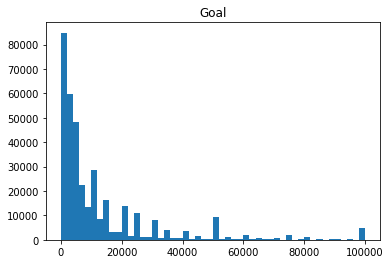

In [34]:
plt.hist(ks.goal, range=(0,100000), bins=50);
plt.title('Goal');

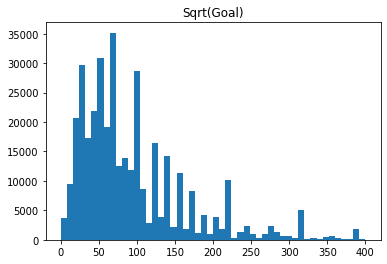

In [35]:
plt.hist(np.sqrt(ks.goal), range=(0,400), bins=50);
plt.title('Sqrt(Goal)');

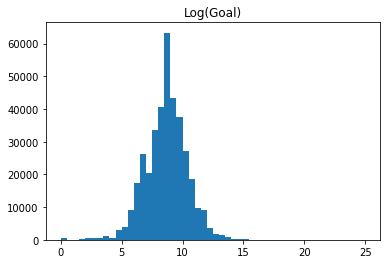

In [36]:
plt.hist(np.log(ks.goal), range=(0, 25), bins=50);
plt.title('Log(Goal)');

The log transformation won't help the model since tree-based models are scale invariant but it should help with linear models or neural networks.

Other transformations include squares and other powers, exponentials, etc. They might help discriminate the model like the kernel trick for SVMs but it takes a bit of experimentation to see what works. One method is to create new features and later choose the best ones with feature selection algorithms. 

# Feature Generation: Exercises 

In [38]:
# Create features from   timestamps
click_data = pd.read_csv('D:/input/feature-engineering-data/train_sample.csv', 
                         parse_dates=['click_time'])
click_times = click_data['click_time']
clicks = click_data.assign(day=click_times.dt.day.astype('uint8'),
                           hour=click_times.dt.hour.astype('uint8'),
                           minute=click_times.dt.minute.astype('uint8'),
                           second=click_times.dt.second.astype('uint8'))

# Label encoding for categorical features
cat_features = ['ip', 'app', 'device', 'os', 'channel']
for feature in cat_features:
    label_encoder = preprocessing.LabelEncoder()
    clicks[feature] = label_encoder.fit_transform(clicks[feature])
    
def get_data_splits(dataframe, valid_fraction=0.1):

    dataframe = dataframe.sort_values('click_time')
    valid_rows = int(len(dataframe) * valid_fraction)
    train = dataframe[:-valid_rows * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_rows * 2:-valid_rows]
    test = dataframe[-valid_rows:]
    
    return train, valid, test

def train_model(train, valid, test=None, feature_cols=None):
    if feature_cols is None:
        feature_cols = train.columns.drop(['click_time', 'attributed_time',
                                           'is_attributed'])
    dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])
    
    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    num_round = 1000
    print("Training model. Hold on a minute to see the validation score")
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], 
                    early_stopping_rounds=20, verbose_eval=False)
    
    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['is_attributed'], valid_pred)
    print(f"Validation AUC score: {valid_score}")
    
    if test is not None: 
        test_pred = bst.predict(test[feature_cols])
        test_score = metrics.roc_auc_score(test['is_attributed'], test_pred)
        return bst, valid_score, test_score
    else:
        return bst, valid_score

print("Baseline model score")
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

Baseline model score
Training model. Hold on a minute to see the validation score
Validation AUC score: 0.9324771929824561


In [40]:
import itertools

cat_features = ['ip', 'app', 'device', 'os', 'channel']
interactions = pd.DataFrame(index=clicks.index)

# Iterate through each pair of features, combine them into interaction features
for col1, col2 in itertools.combinations(cat_features, 2):
    new_col_name = '_'.join([col1, col2])
    
    # Convert to strings and combine
    new_values = clicks[col1].map(str) + '_'  + clicks[col2].map(str)
    
    encoder = preprocessing.LabelEncoder()
    interactions[new_col_name] = encoder.fit_transform(new_values)

In [41]:
clicks = clicks.join(interactions)
print("Score with interactions")
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

Score with interactions
Training model. Hold on a minute to see the validation score
Validation AUC score: 0.9143819548872181


In [42]:
def count_past_events(series, time_window='6H'):
    series = pd.Series(series.index, index=series)
    # Subtract 1 so the current event isn't counted
    past_events = series.rolling(time_window).count() -1
    return past_events

In [44]:
# Loading in from saved Parquet file
past_events = pd.read_parquet('D:/input/feature-engineering-data/past_6hr_events.pqt')
clicks['ip_past_6hr_counts'] = past_events

train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

Training model. Hold on a minute to see the validation score
Validation AUC score: 0.9382075187969923


In [45]:
def time_diff(series):
    """Returns a series with the time since the last timestamp in seconds."""
    ____
    return series.diff().dt.total_seconds()

# Loading in from saved Parquet file
past_events = pd.read_parquet('D:/input/feature-engineering-data/time_deltas.pqt')
clicks['past_events_6hr'] = past_events

train, valid, test = get_data_splits(clicks.join(past_events))
_ = train_model(train, valid)

Training model. Hold on a minute to see the validation score
Validation AUC score: 0.9135097744360904


In [47]:
def previous_attributions(series):
    """Returns a series with the number of times an app has been downloaded."""
    sums = series.expanding(min_periods=2).sum() - series
    return sums

# Loading in from saved Parquet file
past_events = pd.read_parquet('D:/input/feature-engineering-data/downloads.pqt')
clicks['ip_past_6hr_counts'] = past_events

train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

Training model. Hold on a minute to see the validation score
Validation AUC score: 0.9140691729323309


# Feature Selection



In [1]:
%matplotlib inline

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

ks = pd.read_csv('D:/input/kickstarter-projects/ks-projects-201801.csv',
                 parse_dates=['deadline', 'launched'])

# Drop live projects
ks = ks.query('state != "live"')

# Add outcome column, "successful" == 1, others are 0
ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))

# Timestamp features
ks = ks.assign(hour=ks.launched.dt.hour,
               day=ks.launched.dt.day,
               month=ks.launched.dt.month,
               year=ks.launched.dt.year)

# Label encoding
cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()
encoded = ks[cat_features].apply(encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline_data = ks[data_cols].join(encoded)

cat_features = ['category', 'currency', 'country']
interactions = pd.DataFrame(index=ks.index)
for col1, col2 in itertools.combinations(cat_features, 2):
    new_col_name = '_'.join([col1, col2])
    # Convert to strings and combine
    new_values = ks[col1].map(str) + "_" + ks[col2].map(str)
    label_enc = LabelEncoder()
    interactions[new_col_name] = label_enc.fit_transform(new_values)
baseline_data = baseline_data.join(interactions)

launched = pd.Series(ks.index, index=ks.launched, name="count_7_days").sort_index()
count_7_days = launched.rolling('7d').count() - 1
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(ks.index)

baseline_data = baseline_data.join(count_7_days)

def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas = timedeltas.fillna(timedeltas.max())

baseline_data = baseline_data.join(timedeltas.rename({'launched': 'time_since_last_project'}, axis=1))

def get_data_splits(dataframe, valid_fraction=0.1):
    valid_fraction = 0.1
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test

def train_model(train, valid):
    feature_cols = train.columns.drop('outcome')

    dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['outcome'], valid_pred)
    print(f"Validation AUC score: {valid_score:.4f}")
    return bst

Large feature sets can cause the overmatch on the features and slow matching due to number of features to be processed. ANOVA and χ2 are methods for testing statistical relevance to the data.

Scikit-learn's feature selection module, `feature_selection.SelectKBest`, returns the K best features given some scoring functions. Three different scoring functions are given by hte module for classification: χ2, ANOVA F-value, and the mutual information score. The score might underestimate the relation between the features and targe if the relationship is nonlinear. The mutual information score is nonparametric wich can highlight nonlinear relationships.

The scoring function bases the number of features to be kept using `SelectKBest`. The selected features are returned in an array using `.fit_transform(features, target)`.

In [2]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_cols = baseline_data.columns.drop('outcome')

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(baseline_data[feature_cols], baseline_data['outcome'])
X_new

array([[2015.,    5.,    9.,   18., 1409.],
       [2017.,   13.,   22.,   31.,  957.],
       [2013.,   13.,   22.,   31.,  739.],
       ...,
       [2010.,   13.,   22.,   31.,  238.],
       [2016.,   13.,   22.,   31., 1100.],
       [2011.,   13.,   22.,   31.,  542.]])

The statistical tests calculated using the all the data and this means information from the validation and test sets could influence the features to keep, introducing source leakage. The features should only be selected using the training sets.

In [3]:
feature_cols = baseline_data.columns.drop('outcome')
train, valid, _ = get_data_splits(baseline_data)

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(train[feature_cols], train['outcome'])
X_new

array([[2.015e+03, 5.000e+00, 9.000e+00, 1.800e+01, 1.409e+03],
       [2.017e+03, 1.300e+01, 2.200e+01, 3.100e+01, 9.570e+02],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 7.390e+02],
       ...,
       [2.011e+03, 1.300e+01, 2.200e+01, 3.100e+01, 5.150e+02],
       [2.015e+03, 1.000e+00, 3.000e+00, 2.000e+00, 1.306e+03],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 1.084e+03]])

It should be noted that the selected features are different from when the entire dataset is used. Now the features are selected, but only for the training set. The columns that were dropped by `SelectKBest` need to also be dropped from the validation and test sets. The columns dropped can be found using `.inverse_transform` to shape the data back into its original form.

In [4]:
# Get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

,goal,hour,day,month,year,category,currency,country,category_currency,category_country,currency_country,count_7_days,time_since_last_project
0,0.0,0.0,0.0,0.0,2015.0,0.0,5.0,9.0,0.0,0.0,18.0,1409.0,0.0
1,0.0,0.0,0.0,0.0,2017.0,0.0,13.0,22.0,0.0,0.0,31.0,957.0,0.0
2,0.0,0.0,0.0,0.0,2013.0,0.0,13.0,22.0,0.0,0.0,31.0,739.0,0.0
3,0.0,0.0,0.0,0.0,2012.0,0.0,13.0,22.0,0.0,0.0,31.0,907.0,0.0
4,0.0,0.0,0.0,0.0,2015.0,0.0,13.0,22.0,0.0,0.0,31.0,1429.0,0.0


The DataFrame returned has the same index and columns as the training set, but the dropped columns are filled with zeros. The selected columns are now found by choosing the features where the variance is non-zero.

In [5]:
# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns = selected_features.columns[selected_features.var() != 0]

# Get the valid dataset with the selected features.
valid[selected_columns].head()

,year,currency,country,currency_country,count_7_days
302896,2015,13,22,31,1534.0
302897,2013,13,22,31,625.0
302898,2014,5,9,18,851.0
302899,2014,13,22,31,1973.0
302900,2014,5,9,18,2163.0


## L1 regularization

Univariate methods consider only one feature at a time when making a select decision. L1 regularization can be used instead for selection from all the features using a linearl model. This type of regularization (sometimes called Lasso) penalizes  the absolute magnitude of the coefficients, as compare to the L2 (Ridge) regression which penailzes the square of the coefficients.

As the strength of regularization is increased, features which are less important for predicting the target are set to 0. This allows features to be selected using the regularization parameter. The best performance can be chosen using a hold-out set or with features that are decidedly kept.

For regression problems the `sklearn.linear_model.Lasso` or `sklearn.linear_model.LogisticRegression` for classification. These can be used along with `sklearn.feature_selection.SelectFromModel` to select non-zero coeffficients. The code is otherwise similar to the univariant tests.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

train, valid, _ = get_data_splits(baseline_data)

X, y = train[train.columns.drop("outcome")], train['outcome']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", solver='liblinear', random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

array([[1.000e+03, 1.200e+01, 1.100e+01, ..., 1.900e+03, 1.800e+01,
        1.409e+03],
       [3.000e+04, 4.000e+00, 2.000e+00, ..., 1.630e+03, 3.100e+01,
        9.570e+02],
       [4.500e+04, 0.000e+00, 1.200e+01, ..., 1.630e+03, 3.100e+01,
        7.390e+02],
       ...,
       [2.500e+03, 0.000e+00, 3.000e+00, ..., 1.830e+03, 3.100e+01,
        5.150e+02],
       [2.600e+03, 2.100e+01, 2.300e+01, ..., 1.036e+03, 2.000e+00,
        1.306e+03],
       [2.000e+04, 1.600e+01, 4.000e+00, ..., 9.200e+02, 3.100e+01,
        1.084e+03]])

Similar to the univariant tests, an array is returned with the select features. The returned array will need to be converted back into a DataFrame so the columns can be selected.

In [7]:
# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]

In this case with the L1 parameter `C=1`, the `time_since_last_project` column is dropped.

In general, feature selection with L1 regularization is more powerful than the univariate tests, but can also be very slow when there is a lot of data and a lot of features. Univariate tests will be much faster on large datasets but have worse performance.

# Exercises

In [12]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics
import lightgbm as lgb

import os

clicks = pd.read_parquet('D:/input/feature-engineering-data/baseline_data.pqt')
data_files = ['count_encodings.pqt',
              'catboost_encodings.pqt',
              'interactions.pqt',
              'past_6hr_events.pqt',
              'downloads.pqt',
              'time_deltas.pqt',
              'svd_encodings.pqt']
data_root = 'D:/input/feature-engineering-data'
for file in data_files:
    features = pd.read_parquet(os.path.join(data_root, file))
    clicks = clicks.join(features)

def get_data_splits(dataframe, valid_fraction=0.1):

    dataframe = dataframe.sort_values('click_time')
    valid_rows = int(len(dataframe) * valid_fraction)
    train = dataframe[:-valid_rows * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_rows * 2:-valid_rows]
    test = dataframe[-valid_rows:]
    
    return train, valid, test

def train_model(train, valid, test=None, feature_cols=None):
    if feature_cols is None:
        feature_cols = train.columns.drop(['click_time', 'attributed_time',
                                           'is_attributed'])
    dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])
    
    param = {'num_leaves': 64, 'objective': 'binary', 
             'metric': 'auc', 'seed': 7}
    num_round = 1000
    print("Training model!")
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], 
                    early_stopping_rounds=20, verbose_eval=False)
    
    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['is_attributed'], valid_pred)
    print(f"Validation AUC score: {valid_score}")
    
    if test is not None: 
        test_pred = bst.predict(test[feature_cols])
        test_score = metrics.roc_auc_score(test['is_attributed'], test_pred)
        return bst, valid_score, test_score
    else:
        return bst, valid_score 

In [13]:
train, valid, test = get_data_splits(clicks)
_, baseline_score = train_model(train, valid)

Training model!
Validation AUC score: 0.9658334271834417


In [15]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_cols = clicks.columns.drop(['click_time', 'attributed_time', 'is_attributed'])
train, valid, test = get_data_splits(clicks)

# Create the selector, keeping 40 features
selector = SelectKBest(f_classif, k=40)

# Use the selector to retrieve the best features
X_new = selector.fit_transform(train[feature_cols], train['is_attributed']) 

# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(selector.inverse_transform(X_new),
                                index=train.index,
                                columns=feature_cols)

# Find the columns that were dropped
dropped_columns = selected_features.columns[selected_features.var() == 0]

MemoryError: Unable to allocate 1.23 GiB for an array with shape (72, 2300561) and data type float64

In [ ]:
_ = train_model(train.drop(dropped_columns, axis=1), 
                valid.drop(dropped_columns, axis=1))

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

def select_features_l1(X, y):
    """Return selected features using logistic regression with an L1 penalty."""
    logistic = LogisticRegression(C=0.1, penalty="l1", solver='liblinear', random_state=7).fit(X, y)
    model = SelectFromModel(logistic, prefit=True)
    X_new = model.transform(X)
    # Get back the kept features as a DataFrame with dropped columns as all 0s
    selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                     index=X.index,
                                     columns=X.columns)

    # Dropped columns have values of all 0s, keep other columns 
    selected_columns = selected_features.columns[selected_features.var() != 0]
    
    return selected_columns

In [17]:
n_samples = 10000
X, y = train[feature_cols][:n_samples], train['is_attributed'][:n_samples]
selected = select_features_l1(X, y)

dropped_columns = feature_cols.drop(selected)
_ = train_model(train.drop(dropped_columns, axis=1), 
                valid.drop(dropped_columns, axis=1))

MemoryError: Unable to allocate 1011. MiB for an array with shape (72, 1840449) and data type float64